In [2]:
import pandas as pd 

import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
import xgboost as xgb

import sys
sys.path.append('../../data/')
import cleaner as dc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
df = pd.read_csv('data/persuasion_dataset.csv')
df.shape

,label,ad
0,1,in the first two months of 2018 around 1000 ch...
1,1,i showed up to honor black lives i spoke in pr...
2,1,i doyou should that tooi am sure you are spend...
3,1,we want to launch a blistering attack on repub...
4,0,road policing units to step in while gosafe em...
...,...,...
13109,1,an official statement from the hoa board of di...
13110,0,on tuesday wendy is announced that it would be...
13111,1,ticktock there is less than weeks until novemb...
13112,0,operating profit rose to eur 135 mn from eur 9...


In [13]:
# Lower case
df['ad']= df['ad'].apply(lambda x: x.lower())

# Removing punctuations
df['ad']= df['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df['ad']= df['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df['ad']= df['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df['ad']= df['ad'].apply(dc.denoise_text)

#Apply function on review column
df['ad']= df['ad'].apply(dc.remove_stopwords)

#Apply function on review column
df['ad']= df['ad'].apply(dc.remove_special_characters)

#Apply function on review column
df['ad']= df['ad'].apply(dc.simple_stemmer)

In [14]:
X_train, X_test,  y_train, y_test= train_test_split(df['ad'], df['label'], test_size =0.2, random_state=0)

In [15]:
tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [16]:
xgb_clf = xgb.XGBClassifier(  
      objective='binary:logistic' ,
        eta=0.04
    )
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.04,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0399999991, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

accuracy:   0.874
                precision    recall  f1-score   support

non persuasive       0.81      0.97      0.88      1308
    persuasive       0.97      0.77      0.86      1315

      accuracy                           0.87      2623
     macro avg       0.89      0.87      0.87      2623
  weighted avg       0.89      0.87      0.87      2623

confusion matrix:
[[1273   35]
 [ 296 1019]]



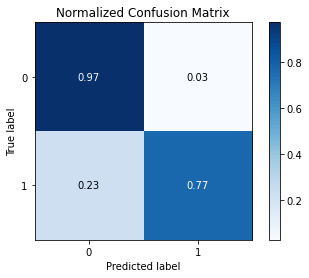

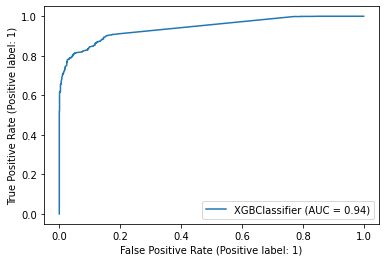

In [17]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# compute the performance measures
score1 = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predictions, target_names=['non persuasive', 'persuasive']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [21]:
df_val = pd.read_csv("data/sample_persuasion.csv")
df_val.shape

(319, 2)

In [22]:
# Lower case
df_val['ad']= df_val['ad'].apply(lambda x: x.lower())

# Removing punctuations
df_val['ad']= df_val['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df_val['ad']= df_val['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df_val['ad']= df_val['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df_val['ad']= df_val['ad'].apply(dc.denoise_text)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.remove_stopwords)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.remove_special_characters)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.simple_stemmer)

accuracy:   0.752
                precision    recall  f1-score   support

non persuasive       0.55      0.83      0.66        92
    persuasive       0.91      0.72      0.81       227

      accuracy                           0.75       319
     macro avg       0.73      0.77      0.73       319
  weighted avg       0.81      0.75      0.76       319

confusion matrix:
[[ 76  16]
 [ 63 164]]



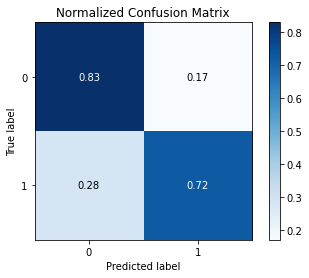

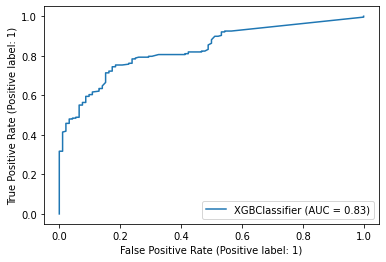

In [23]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['label']

y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'non persuasive', 'persuasive']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)